In [1]:
# standart libs
import sys
import random
import copy
from operator import itemgetter
from PIL import Image
import time


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import scipy.stats as ss
from skimage import measure
from matplotlib import gridspec


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# create basic form
xvals = np.linspace(0, np.pi, 1000)
yvals = np.exp(-xvals) * np.sin(np.pi * xvals)
# rescale
xvals = (xvals / np.pi) * 1000
yvals -= np.min(yvals)
yvals = (yvals / np.max(yvals)) * 500 + 250

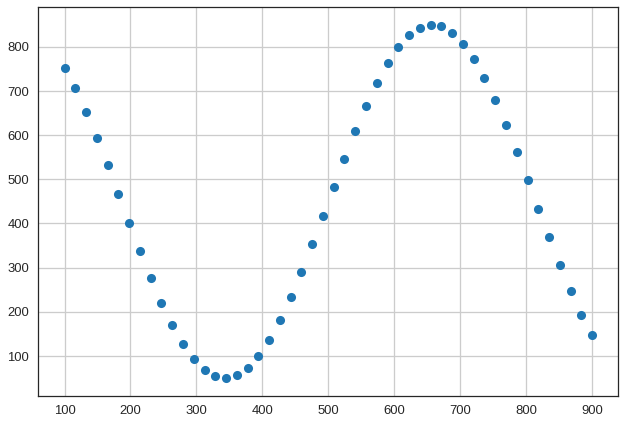

In [4]:


# sinus curve
xvals = np.linspace(-4, 4, 50)
yvals = np.sin(xvals)

# scale up and transform
xvals = xvals * 100 + 500
yvals = yvals * 400 + 450

# plot
plt.plot(xvals, yvals, 'o')
plt.grid()



In [5]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)



Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [6]:
# meta
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }

# create surface_points
df_sp = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'smooth'])
df_sp['X'] = xvals
df_sp['Y'] = 500
df_sp['Z'] = yvals
df_sp['surface'] = 'rock1'
df_sp['smooth'] = 0.000001

# create orientation
df_or = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
df_or['X'] = xvals[np.where(yvals == np.max(yvals))]
df_or['Y'] = 500 + 1
df_or['Z'] = np.max(yvals)
df_or['formation'] = 'rock1'
df_or['dip'] = 0
df_or['azimuth'] = 90
df_or['polarity'] = 1

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()
Run realizations setup checks until stable workflow.
HOTFIX in gempy/core/gempy_api.py 328


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


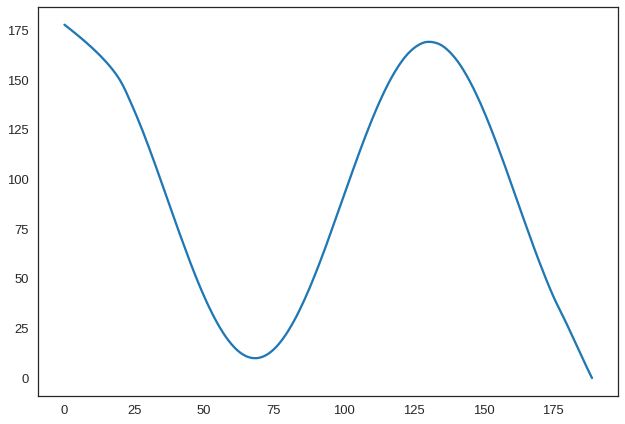

In [7]:
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent,
        section=section,
        series_df=series_df,
        surfaces_df=surfaces_df,
        surface_points_original_df=df_sp,
        orientations_original_df=df_or
)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
contours = post_pro.compute_section_contours(geo_model)
interpolated_line = contours['rock1']
interpolated_line.shape
plt.plot(interpolated_line[:,0], interpolated_line[:,1])

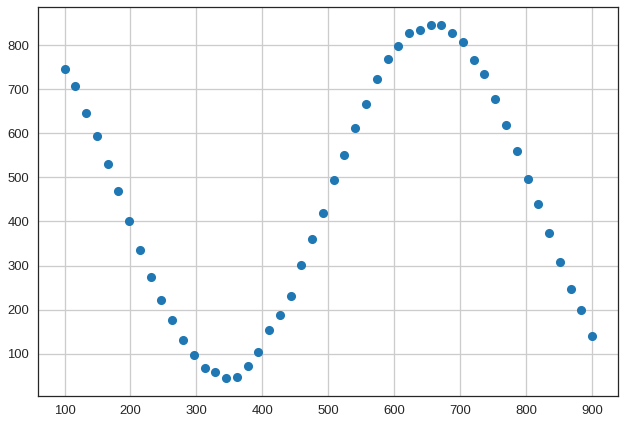

In [8]:
# sinus curve
xvals = np.linspace(-4, 4, 50)
yvals = np.sin(xvals)

# scale up and transform
xvals = xvals * 100 + 500
yvals = yvals * 400 + 450

# add noise
noise = np.random.normal(0,5,len(yvals))
yvals = yvals + noise

# plot
plt.plot(xvals, yvals, 'o')
plt.grid()

In [10]:
# meta
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }

# create surface_points
df_sp = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'smooth'])
df_sp['X'] = xvals
df_sp['Y'] = 500
df_sp['Z'] = yvals
df_sp['surface'] = 'rock1'
df_sp['smooth'] = 0.0001

# create orientation
df_or = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
df_or['X'] = xvals[np.where(yvals == np.max(yvals))]
df_or['Y'] = 500 + 1
df_or['Z'] = np.max(yvals)
df_or['formation'] = 'rock1'
df_or['dip'] = 0
df_or['azimuth'] = 90
df_or['polarity'] = 1

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()
Run realizations setup checks until stable workflow.
HOTFIX in gempy/core/gempy_api.py 328


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


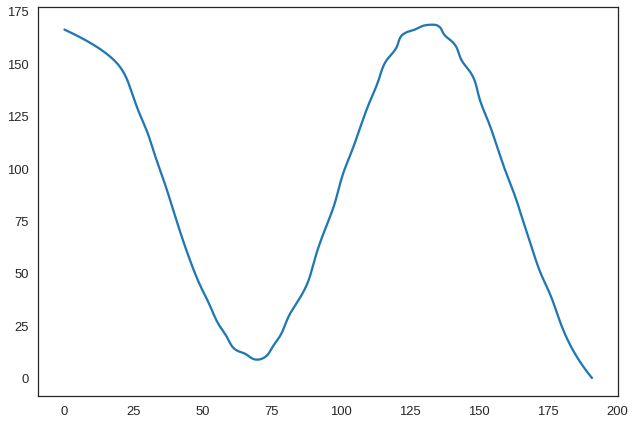

In [11]:
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent,
        section=section,
        series_df=series_df,
        surfaces_df=surfaces_df,
        surface_points_original_df=df_sp,
        orientations_original_df=df_or
)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
contours = post_pro.compute_section_contours(geo_model)
interpolated_line = contours['rock1']
interpolated_line.shape
plt.plot(interpolated_line[:,0], interpolated_line[:,1])


In [12]:
# meta
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }

# create surface_points
df_sp = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'smooth'])
df_sp['X'] = xvals
df_sp['Y'] = 500
df_sp['Z'] = yvals
df_sp['surface'] = 'rock1'
df_sp['smooth'] = 0.1

# create orientation
df_or = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
df_or['X'] = xvals[np.where(yvals == np.max(yvals))]
df_or['Y'] = 500 + 400
df_or['Z'] = np.max(yvals)
df_or['formation'] = 'rock1'
df_or['dip'] = 0
df_or['azimuth'] = 90
df_or['polarity'] = 1

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.
HOTFIX in gempy/core/gempy_api.py 328


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


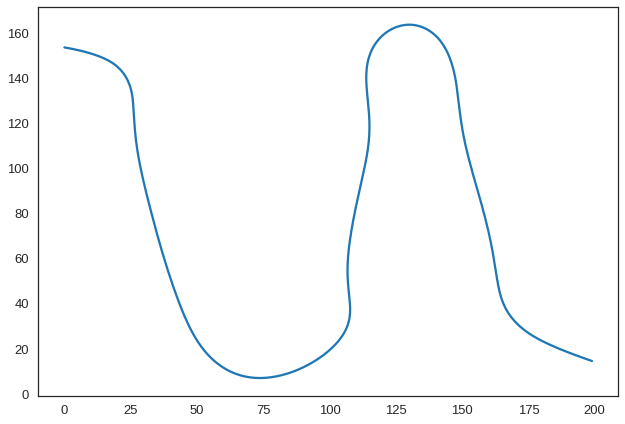

In [13]:
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent,
        section=section,
        series_df=series_df,
        surfaces_df=surfaces_df,
        surface_points_original_df=df_sp,
        orientations_original_df=df_or
)

geo_model.modify_surface_points(
    geo_model.surface_points.df.index, smooth=0.1
)
geo_model.update_to_interpolator()


if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    
contours = post_pro.compute_section_contours(geo_model)
interpolated_line = contours['rock1']
interpolated_line.shape
plt.plot(interpolated_line[:,0], interpolated_line[:,1])

In [14]:
def run_plot_realization(smooth_idx, noise_idx, smooth, noise):
    
    # artiicial line
    # sinus curve
    xvals = np.linspace(-4, 4, 50)
    yvals = np.sin(xvals)

    # scale up and transform
    xvals = xvals * 100 + 500
    yvals = yvals * 400 + 450

    # add noise
    noise = np.random.normal(0,noise[noise_idx],len(yvals))
    yvals = yvals + noise       
    
    # meta
    geo_model_extent = [0,1000,0,1000,0,1000]
    section = {
        'p1': [0, 500],
        'p2': [1000, 500],
        'resolution': [200, 200]
    }

    # sereis
    series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
    series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
    series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

    # surfaces
    surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
    surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
    surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }

    # create surface_points
    df_sp = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'smooth'])
    df_sp['X'] = xvals
    df_sp['Y'] = 500
    df_sp['Z'] = yvals
    df_sp['surface'] = 'rock1'
    df_sp['smooth'] = 0.001

    # create orientation
    df_or = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
    df_or['X'] = xvals[np.where(yvals == np.max(yvals))]
    df_or['Y'] = 500 + 1
    df_or['Z'] = np.max(yvals)
    df_or['formation'] = 'rock1'
    df_or['dip'] = 0
    df_or['azimuth'] = 90
    df_or['polarity'] = 1
    
    real_setup.setup_realization(
            geo_model=geo_model,
            geo_model_extent=geo_model_extent,
            section=section,
            series_df=series_df,
            surfaces_df=surfaces_df,
            surface_points_original_df=df_sp,
            orientations_original_df=df_or
    )

    geo_model.modify_surface_points(
        geo_model.surface_points.df.index, smooth=smooth[smooth_idx]
    )
    geo_model.update_to_interpolator()


    if real_run.check_setup_single_realization(geo_model):
        solution = gp.compute_model(model=geo_model, sort_surfaces=False)

    contours = post_pro.compute_section_contours(geo_model)
    interpolated_line = contours['rock1']
    interpolated_line.shape
    
    axs[noise_idx,smooth_idx].plot(interpolated_line[:,0], interpolated_line[:,1])
    axs[noise_idx,smooth_idx].set_title(f'Smooth: {smooth_vals[smooth_idx]}, Noise: {noise_vals[noise_idx]}')
    axs[noise_idx,smooth_idx].set_yticklabels([])
    axs[noise_idx,smooth_idx].set_xticklabels([])
    axs[noise_idx,smooth_idx].set_xlim([0,200])
    axs[noise_idx,smooth_idx].set_ylim([0,200])

    lines[f'{smooth}_{noise}'] = interpolated_line

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


HOTFIX in gempy/core/gempy_api.py 328


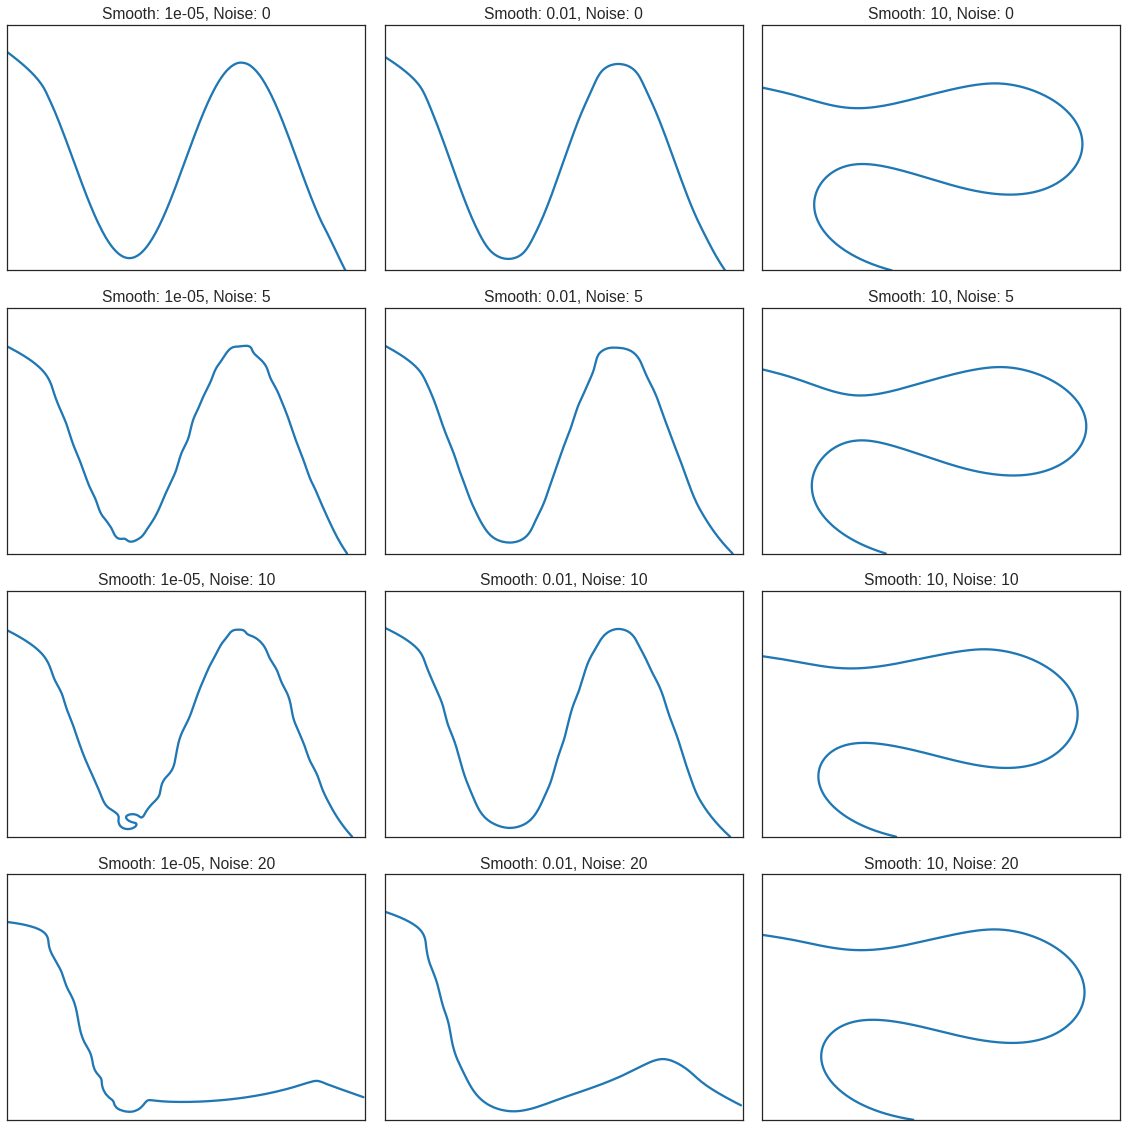

In [16]:
smooth_vals = [0.00001, 0.01 ,10]
noise_vals = [0, 5, 10, 20]
lines = {}

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(16, 16))

for i in range(len(noise_vals)):
    
    for ii in range(len(smooth_vals)):        

        run_plot_realization(smooth=smooth_vals, smooth_idx=ii, noise=noise_vals, noise_idx=i)
        
plt.tight_layout()
fig.savefig('../document/figures/discussion_smooth.png')
plt.show()